In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np

In [30]:
complaints = pd.read_csv("complaints_25Nov21.csv")
complaints


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,NaN,NaN,JPMORGAN CHASE & CO.,FL,33133,NaN,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,JPMORGAN CHASE & CO.,NY,10312,NaN,NaN,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,NaN,NaN,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,NaN,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


In [31]:
# Filter the data for top 5 banks and until 2017
top_5_banks = ['BANK OF AMERICA, NATIONAL ASSOCIATION', 'WELLS FARGO & COMPANY', 'JPMORGAN CHASE & CO.', 'CITIBANK, N.A.', 'U.S. BANCORP']
complaints = complaints[(complaints['Company'].isin(top_5_banks)) & (complaints['Date received'] <= '2017-12-31')]

# Select predictor (X) and predicted (y) variables
X = complaints[['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via',
               'Company response to consumer', 'Timely response?']]
y = complaints['Consumer disputed?']

# Convert y to 0s and 1s using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Perform one-hot encoding for categorical features
X = pd.get_dummies(X, columns=['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via',
               'Company response to consumer', 'Timely response?'])

# Split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Check the proportion of complaints in the training dataset that are disputed
if (y_train == 1).mean() < 0.3:
    undersampler = RandomUnderSampler(random_state=123)
    X_train, y_train = undersampler.fit_resample(X_train, y_train)
# Check the proportion of complaints in the training dataset that are disputed
#if (y_train == 1).mean() < 0.3:
 #   # Use SMOTE to oversample the minority class
  #  smote = SMOTE(random_state=123)
   # X_train, y_train = smote.fit_resample(X_train, y_train)
# Train an XGBoost Classifier
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model_xgb.predict(X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


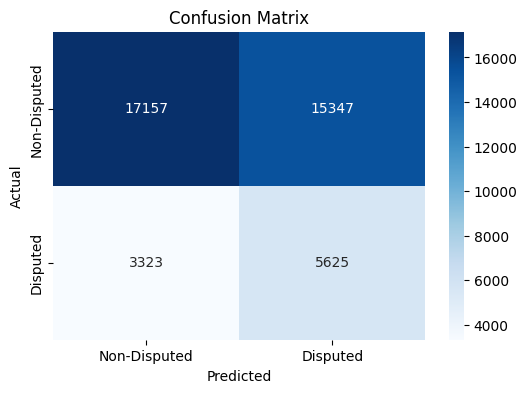

Classification Report:                precision    recall  f1-score   support

           0       0.84      0.53      0.65     32504
           1       0.27      0.63      0.38      8948

    accuracy                           0.55     41452
   macro avg       0.55      0.58      0.51     41452
weighted avg       0.71      0.55      0.59     41452



In [36]:
# Define class labels
class_labels = ["Non-Disputed", "Disputed"]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report: ", report)

In [37]:
# Question 1
proportion_disputed = (y_test == 1).mean()
print(f"Proportion of consumers who raised a dispute in the test set: {proportion_disputed:.6f}")

Proportion of consumers who raised a dispute in the test set: 0.215864


In [38]:
# Question 2
proportion_disputed_train = (y_train == 1).mean()
print(f"Proportion of consumers who raised a dispute in the training set after undersampling: {proportion_disputed_train:.6f}")

Proportion of consumers who raised a dispute in the training set after undersampling: 0.500000


In [39]:
from sklearn.metrics import recall_score

# Question 3
recall = recall_score(y_test, y_pred)
print(f"Recall for 'Consumer disputed?' = 'Yes' on the test set: {recall:.2f}")

Recall for 'Consumer disputed?' = 'Yes' on the test set: 0.63


In [44]:
# Question 4
total_cost_no_model = base_case_cost.sum()
print(f"Total cost without the model: ${total_cost_no_model:,.0f}")



Total cost without the model: $8,529,720


In [45]:
#Question 5
# Cost when model predicts dispute and actually disputed
True_NoDispute_Cost = 100 * conf_matrix[0, 0]

# Cost when model predicts dispute and no actual dispute
False_Dispute_Cost = 190 * conf_matrix[0,1]

# Cost when model predicts NoDispute and actually disputed
False_NoDispute_Cost = 600 * conf_matrix[1,0]

# Cost when model predicts NoDispute correctly
True_Dispute_Cost = 190 * conf_matrix[1,1]

Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
Total_cost

7694180

In [41]:
# Calculate the total cost based on the model results with the default threshold
total_cost_model_default = (y_pred * 500 + (1 - y_pred) * 100).sum()
total_cost_model_default = total_cost_model_default + y_pred.sum() * 90
print(f"Total cost based on the model results with default threshold: ${total_cost_model_default:,.0f}")


Total cost based on the model results with default threshold: $14,421,480


In [26]:
# Calculate the total cost based on the model results with default threshold
total_cost_model_default = total_cost.sum()
print(f"Total cost based on the model results with default threshold: ${total_cost_model_default:,.0f}")


Total cost based on the model results with default threshold: $14,421,480


In [28]:
total_cost_model_default = (y_pred * 500 + (1 - y_pred) * 100).sum()
total_cost_model_default = total_cost_model_default + y_pred.sum() * 90
print(f"Total cost based on the model results with default threshold: ${total_cost_model_default:,.0f}")


Total cost based on the model results with default threshold: $14,421,480
